In [ ]:
!nvidia-smi

Thu Nov 14 01:03:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import timm
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# Define the transformation (convert to grayscale, then resize to 299x299 for Xception)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Data directory
data_dir = '/content/drive/My Drive/Face_Swap_Detection_Face_Edge_Method/train_data'
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Define the split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize the Xception model
def initialize_xception():
    model = timm.create_model('xception', pretrained=True)
    original_conv1 = model.conv1
    # Modify first layer to accept a single channel (grayscale) input
    model.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=original_conv1.out_channels,
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias is not None
    )
    # Average the original weights to match single-channel input
    with torch.no_grad():
        model.conv1.weight = nn.Parameter(original_conv1.weight.sum(dim=1, keepdim=True))
    # Replace the classifier layer to output 2 classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(num_ftrs, 2)
    )
    return model.to(device)

In [ ]:
# Initialize model, loss, optimizer, and learning rate scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = initialize_xception()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Early stopping and tracking variables
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [ ]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / val_size
    val_acc = val_running_corrects.double() / val_size
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model_xception.pth')
        print(f'Saving best model with val loss: {best_val_loss:.4f}')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print('Early stopping triggered')
            break

Epoch 1/50
Train Loss: 0.5499 Acc: 0.7108
Val   Loss: 0.6859 Acc: 0.7117
Saving best model with val loss: 0.6859
Epoch 2/50
Train Loss: 0.4229 Acc: 0.8121
Val   Loss: 0.6542 Acc: 0.7832
Saving best model with val loss: 0.6542
Epoch 3/50
Train Loss: 0.3574 Acc: 0.8471
Val   Loss: 0.3516 Acc: 0.8476
Saving best model with val loss: 0.3516
Epoch 4/50
Train Loss: 0.3117 Acc: 0.8704
Val   Loss: 0.3597 Acc: 0.8753
Epoch 5/50
Train Loss: 0.2889 Acc: 0.8745
Val   Loss: 0.3420 Acc: 0.8579
Saving best model with val loss: 0.3420
Epoch 6/50
Train Loss: 0.2962 Acc: 0.8739
Val   Loss: 0.3891 Acc: 0.8384
Epoch 7/50
Train Loss: 0.2507 Acc: 0.8911
Val   Loss: 0.2726 Acc: 0.8804
Saving best model with val loss: 0.2726
Epoch 8/50
Train Loss: 0.2249 Acc: 0.9100
Val   Loss: 0.3789 Acc: 0.8548
Epoch 9/50
Train Loss: 0.2147 Acc: 0.9138
Val   Loss: 0.3143 Acc: 0.8742
Epoch 10/50
Train Loss: 0.2068 Acc: 0.9149
Val   Loss: 0.3555 Acc: 0.8650
Epoch 11/50
Train Loss: 0.2033 Acc: 0.9166
Val   Loss: 0.3229 Acc: 0.

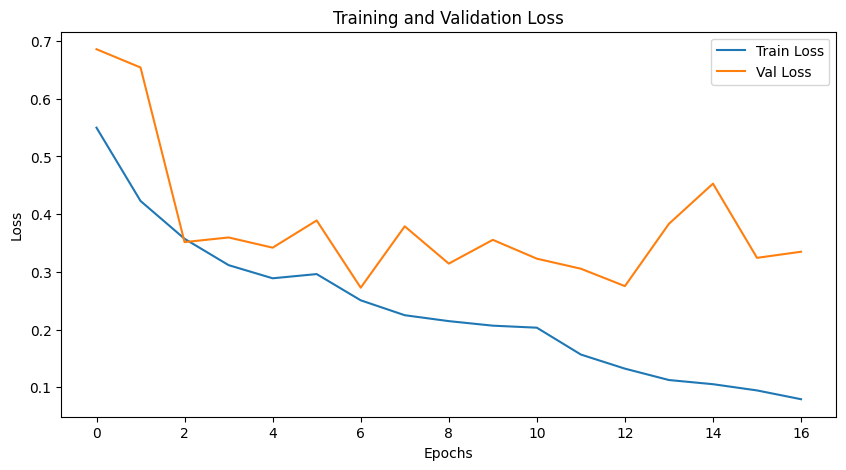

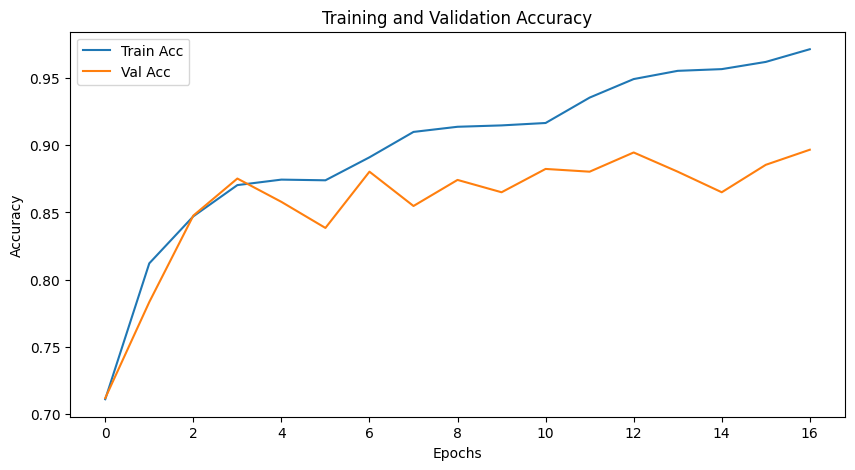

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_model_xception.pth'))

<ipython-input-9-4420a04836f0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_xception.pth'))


<All keys matched successfully>

In [ ]:
# Test the model
test_dir = '/content/drive/My Drive/Face_Swap_Detection_Face_Edge_Method/test_data'
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9173


In [ ]:
# Save the best model for download
from google.colab import files
files.download('best_model_xception.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>